APS data sets were collected at the following conditions:
- 2 MHz filtering on PIN and BIM
- 25 MHz sampling at 12.5M samples (0.5 s time record)

In [11]:
import glob
import h5py
import tomopy
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap

from general.calc_statistics import rmse
from general.misc import create_folder


prj_fld = '/mnt/r/X-ray Tomography/2018_DataSets/'
hdf5_fld = '{0}/APS Data/'.format(prj_fld)
save_fld = create_folder('{0}/APS Tomography/'.format(prj_fld))


def get_data(scans, ind):
    # Initialize arrays
    x = [None] * len(scans)
    theta = [None] * len(scans)
    EPL = [None] * len(scans)
    
    for i, scan in enumerate(list(scans)):
        f = h5py.File('{0}/Scan_{1}.hdf5'.format(hdf5_fld, scan), 'r')
        x[i] = np.array(f['X'])
        theta[i] = np.mean(f['Theta'])
        BIM = np.mean(np.array(f['BIM']), axis=1)
        PIN = np.mean(np.array(f['PINDiode']), axis=1)
        extinction_length = np.log(BIM / PIN)
        offset = np.median(extinction_length[ind:])
        extinction_length -= offset

        # Attenuation coefficient (total w/o coh. scattering - cm^2/g)
        # Convert to mm^2/g for mm, multiply by density in g/mm^3
        # Pure water @ 8 keV
        # <https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html>
        atten_coeff = (1.006*10*(10*10))*(0.001)

        # Calculate EPL and convert to um from mm
        EPL[i] = (extinction_length / atten_coeff) * 1000

    theta = np.radians(theta)
    EPL = np.array(EPL)[:, np.newaxis, :]
    
    return x, theta, EPL

    
# Define y locations at 0.30 gpm
y_30 = [-4, 0, 4, 8]
y_45 = [0, 4, 8]

In [2]:
# Define corresponding scans at 0.30 gpm
scans1_30 = range(819, 836+1)
scans2_30 = range(837, 854+1)
scans3_30 = range(855, 872+1)
scans4_30 = range(873, 890+1)

# Define corresponding scans at 0.45 gpm
scans1_45 = range(1010, 1026+1)
scans2_45 = range(1027, 1043+1)
scans3_45 = range(1044, 1060+1)

# Retrieve spray data
x1, theta1, EPL1 = get_data(scans1_30, -2)
x2, theta2, EPL2 = get_data(scans2_30, -7)
x3, theta3, EPL3 = get_data(scans3_30, -3)
x4, theta4, EPL4 = get_data(scans4_30, -2)
x5, theta5, EPL5 = get_data(scans1_45, -10)
x6, theta6, EPL6 = get_data(scans2_45, -10)
x7, theta7, EPL7 = get_data(scans3_45, -10)

In [3]:
# Find center points
rot_center1 = tomopy.find_center(EPL1, theta1, init=17, ind=0, tol=0.1, sinogram_order=False)
rot_center2 = tomopy.find_center(EPL2, theta2, init=25, ind=0, tol=0.1, sinogram_order=False)
rot_center3 = tomopy.find_center(EPL3, theta3, init=24, ind=0, tol=0.1, sinogram_order=False)
rot_center4 = tomopy.find_center(EPL4, theta4, init=25, ind=0, tol=0.1, sinogram_order=False)

rot_center5 = tomopy.find_center(EPL5, theta5, init=25, ind=0, tol=0.1, sinogram_order=False)
rot_center6 = tomopy.find_center(EPL6, theta6, init=30, ind=0, tol=0.1, sinogram_order=False)
rot_center7 = tomopy.find_center(EPL7, theta7, init=30, ind=0, tol=0.1, sinogram_order=False)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

In [4]:
# Run reconstructions
recon1 = tomopy.recon(EPL1, theta1, center=rot_center1, algorithm='art', sinogram_order=False)
recon2 = tomopy.recon(EPL2, theta2, center=rot_center2, algorithm='art', sinogram_order=False)
recon3 = tomopy.recon(EPL3, theta3, center=rot_center3, algorithm='art', sinogram_order=False)
recon4 = tomopy.recon(EPL4, theta4, center=rot_center4, algorithm='art', sinogram_order=False)

recon5 = tomopy.recon(EPL5, theta5, center=rot_center5, algorithm='art', sinogram_order=False)
recon6 = tomopy.recon(EPL6, theta6, center=rot_center6, algorithm='art', sinogram_order=False)
recon7 = tomopy.recon(EPL7, theta7, center=rot_center7, algorithm='art', sinogram_order=False)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


In [29]:
# Save the data to HDF5 files
EPL_30 = [EPL1, EPL2, EPL3, EPL4]
recon_30 = [recon1, recon2, recon3, recon4]
x_30 = [x1, x2, x3, x4]

for i, _ in enumerate(EPL_30):
    with h5py.File('{0}/slice{1}_0p30gpm.h5'.format(save_fld, i), 'w') as f:
        f.create_dataset('EPL', data=EPL_30[i])
        f.create_dataset('recon', data=recon_30[i])
        f.create_dataset('y', data=y_30[0])
        f.create_dataset('x', data=x_30[i][0])
        f.create_dataset('theta', data=theta1)
        
EPL_45 = [EPL5, EPL6, EPL7]
recon_45 = [recon5, recon6, recon7]
x_45 = [x5, x6, x7]

for i, _ in enumerate(EPL_45):
    with h5py.File('{0}/slice{1}_0p45gpm.h5'.format(save_fld, i), 'w') as f:
        f.create_dataset('EPL', data=EPL_45[i])
        f.create_dataset('recon', data=recon_45[i])
        f.create_dataset('y', data=y_45[0])
        f.create_dataset('x', data=x_45[i][0])
        f.create_dataset('theta', data=theta1)

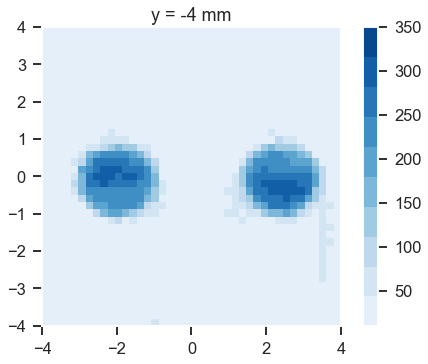

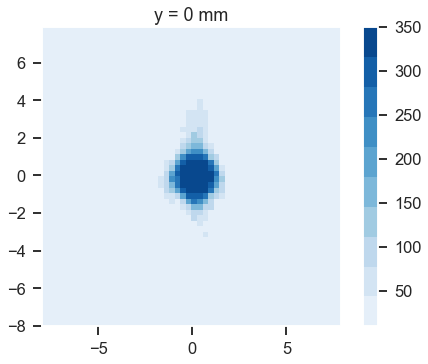

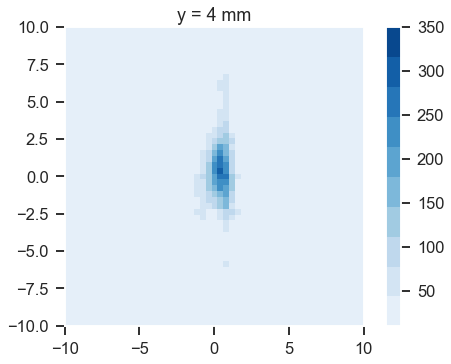

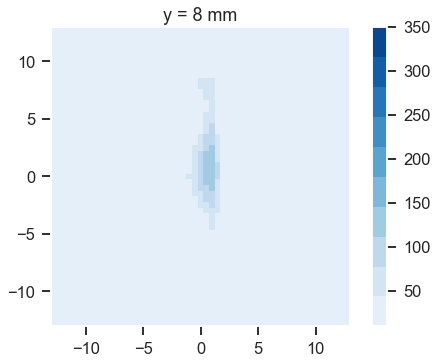

In [31]:
x = [x1, x2, x3, x4]

with plt.style.context(('seaborn')):
    sns.set_context('talk')
    for i, n in enumerate([recon1, recon2, recon3, recon4]):
        fig, ax = plt.subplots()
        cmap = ListedColormap(sns.color_palette('Blues', 10).as_hex())
        im = ax.imshow(n[0,:,:], vmin=10, vmax=350, extent=[x[i][0].min(), x[i][0].max(), x[i][0].min(), x[i][0].max()], cmap=cmap)
        fig.colorbar(im, ax=ax)
        plt.title('y = {} mm'.format(y_30[i]))
        plt.grid(False)
        plt.savefig('{0}/slice{1}_0p30gpm.png'.format(save_fld, i))
        plt.show()

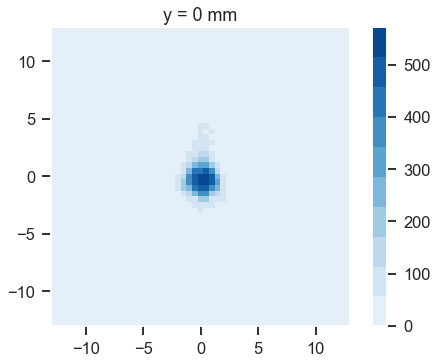

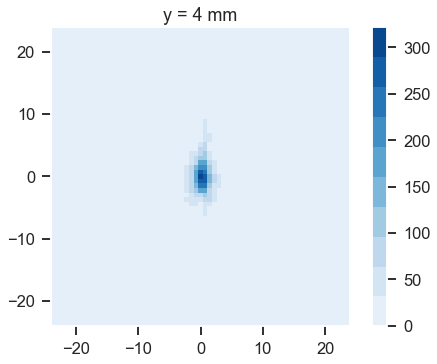

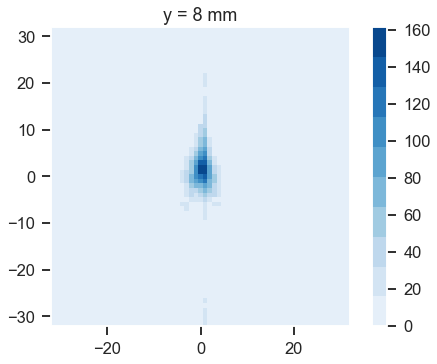

In [30]:
x = [x5, x6, x7]

with plt.style.context(('seaborn')):
    sns.set_context('talk')
    for i, n in enumerate([recon5, recon6, recon7]):
        fig, ax = plt.subplots()
        cmap = ListedColormap(sns.color_palette('Blues', 10).as_hex())
        im = ax.imshow(n[0,:,:], vmin=0, extent=[x[i][0].min(), x[i][0].max(), x[i][0].min(), x[i][0].max()], cmap=cmap)
        fig.colorbar(im, ax=ax)
        plt.title('y = {} mm'.format(y_45[i]))
        plt.grid(False)
        plt.savefig('{0}/slice{1}_0p45gpm.png'.format(save_fld, i))
        plt.show()